# D(St)reams of Anomalies

New York City, otherwise known as "The City that Never Sleeps" can be a great source for fascinating data. In this project, we will examine the habits of these sleepless citizens as they take taxi rides across the city. We will analyze how taxi passenger counts change from day-to-day, and **identify anomalies** in the data we are analyzing.

## Retrieving the Data
This data comes from the [Numenta Anomaly Benchmark (NAB) dataset of NYC Taxi Rates on Github](https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv), but the raw data actually comes from the [NYC Taxi and Limousine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) website. We will begin by loading the dataset into a dataframe:

In [1]:
from os import path
import numpy as np
import pandas as pd

taxi_df = pd.read_csv("data/raw/nyc_taxi.csv")
taxi_df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Let's run through some quick information about this dataset:

In [2]:
taxi_df.shape

(10320, 2)

In [3]:
taxi_df.keys()

Index(['timestamp', 'value'], dtype='object')

There's really not much to say about the dataset itself. There are over ten thousand data points and only 2 columns:

|Key       |Description|
|:---------|:----------|
|timestamp |Timestamp of the data|
|value     |The total amount of taxi passengers in a 30 minute bucket|

## Cleaning Up the Data
There's really not much to clean up in this dataset. The `timestamp` column should be converted into an actual date object:

In [4]:
taxi_df["timestamp"] = pd.to_datetime(taxi_df["timestamp"])
taxi_df["timestamp"].describe()

count                   10320
unique                  10320
top       2014-11-12 04:30:00
freq                        1
first     2014-07-01 00:00:00
last      2015-01-31 23:30:00
Name: timestamp, dtype: object

Let's change the name of `values` to make it more descriptive:

In [5]:
taxi_df = taxi_df.rename(columns={"value": "num_passengers"})
taxi_df.keys()

Index(['timestamp', 'num_passengers'], dtype='object')

Let's check for any missing values:

In [6]:
taxi_df[taxi_df.isna().any(axis=1)].shape[0]

0

Great, no null values! Let's move on to feature engineering:

## Feature Engineering
Because we are trying to detect anomalies, something that might help in our analysis is a score for how far away a point is from the average value, disregarding the outliers. This will help our model determine what is and what is not considered standard:

In [7]:
num_passengers = taxi_df["num_passengers"].values
# Let's get rid of the outliers
num_passengers_length = len(num_passengers)
num_passengers = num_passengers[(num_passengers_length // 8):num_passengers_length-(num_passengers_length // 8)]

# Calculate average and standard deviation
num_passengers_avg = int(np.floor(num_passengers.mean()))
print("Average number of passengers in a 30-minute period: {}".format(num_passengers_avg))
num_passengers_std = num_passengers.std()
print("Standard deviation of passengers in a 30-minute period: {}".format(num_passengers_std))

taxi_df["score_from_avg"] = np.power(((taxi_df["num_passengers"] - num_passengers_avg) / num_passengers_avg), 2)
taxi_df["score_from_avg"].describe()

Average number of passengers in a 30-minute period: 15245
Standard deviation of passengers in a 30-minute period: 6882.639838932542


count    1.032000e+04
mean     2.072349e-01
std      2.315752e-01
min      1.721096e-08
25%      2.078269e-02
50%      9.464351e-02
75%      3.550581e-01
max      2.468475e+00
Name: score_from_avg, dtype: float64

Now let's analyze some data:

## Analysis

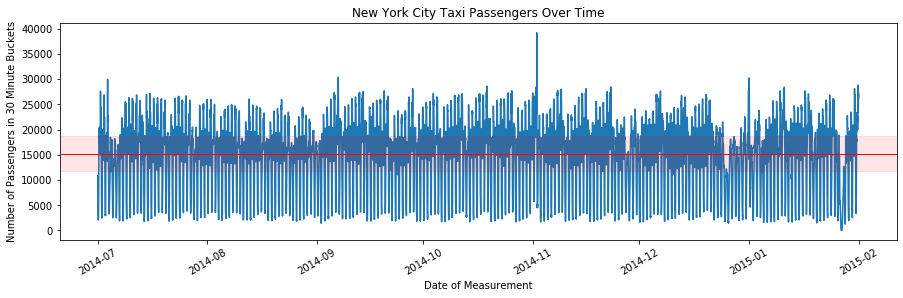

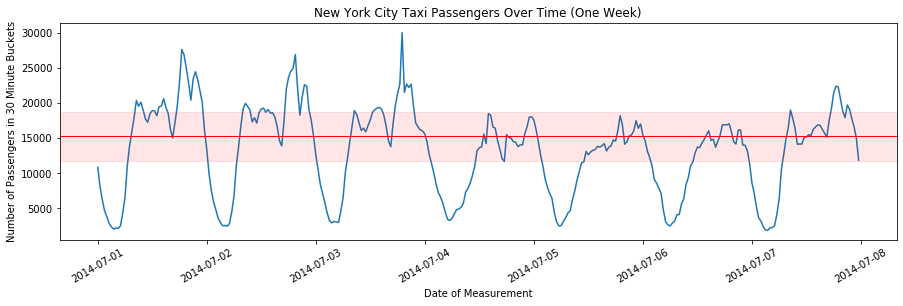

In [9]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def show_taxi_data(data, title):
    plt.figure(figsize=(15, 4))

    plt.plot(data[:,0], data[:,1])
    plt.axhspan(num_passengers_avg - (num_passengers_std / 2), num_passengers_avg + (num_passengers_std / 2),
                color="red", alpha=0.1, zorder=5)
    plt.axhspan(num_passengers_avg - 1, num_passengers_avg + 1, color="red", zorder=6)
    plt.title(title)
    plt.xlabel("Date of Measurement")
    plt.xticks(rotation=30)
    plt.ylabel("Number of Passengers in 30 Minute Buckets")

data = taxi_df.apply(lambda row: np.array(list((row["timestamp"], row["num_passengers"], row["score_from_avg"]))), axis=1)
data = np.array(list(data))
show_taxi_data(data, "New York City Taxi Passengers Over Time")

days_to_show = 7
day_data = data[:days_to_show * 48,:]
show_taxi_data(day_data, "New York City Taxi Passengers Over Time (One Week)")

plt.show()

It looks like we have some cyclic data, and we can already see some anomalies in the first graph. Let's do some anomaly detection to find the anomalies.

## Detecting Anomalies
According to the Kaggle description of the `nyc_taxi.csv` dataset:
> Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm

So we're looking for **5** anomaly days:
* `2014-11-02` (NYC Marathon)
* `2014-11-27` (Thanksgiving)
* `2014-12-25` (Christmas)
* `2015-01-01` (New Years Day)
* According to [this Wikipedia article](https://en.wikipedia.org/wiki/January_2015_North_American_blizzard) it seems the snow storm referenced on the Kaggle description happened around `2015-01-26` to `2015-01-27`

In [10]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

defined_anomalies = [("NYC Marathon", pd.to_datetime(["2014-11-02 00:00", "2014-11-02 23:59"])),
                     ("Thanksgiving", pd.to_datetime(["2014-11-27 00:00", "2014-11-27 23:59"])),
                     ("Christmas", pd.to_datetime(["2014-12-25 00:00", "2014-12-25 23:59"])),
                     ("New Years Day", pd.to_datetime(["2015-01-01 00:00", "2015-01-01 23:59"])),
                     ("Snow Storm", pd.to_datetime(["2015-01-26 00:00", "2015-01-27 23:59"]))]

outliers_fraction = 0.002 # This will be changed depending on the results

# If we use the current data, the model will yell at us for using a timestamp object
converted_data = np.array(data)
converted_data[:,0] = range(len(data))

#### Isolation Forest

In [11]:
if_model = IsolationForest(contamination=outliers_fraction, behaviour="new")
if_pred = if_model.fit_predict(converted_data)

taxi_df_w_anomalies = taxi_df.merge(pd.Series(if_pred, name="anomaly"), left_index=True, right_index=True)
taxi_df_w_anomalies.head()

,timestamp,num_passengers,score_from_avg,anomaly
0,2014-07-01 00:00:00,10844,0.083339,1
1,2014-07-01 00:30:00,8127,0.218002,1
2,2014-07-01 01:00:00,6210,0.351238,1
3,2014-07-01 01:30:00,4656,0.482453,1
4,2014-07-01 02:00:00,3820,0.561639,1


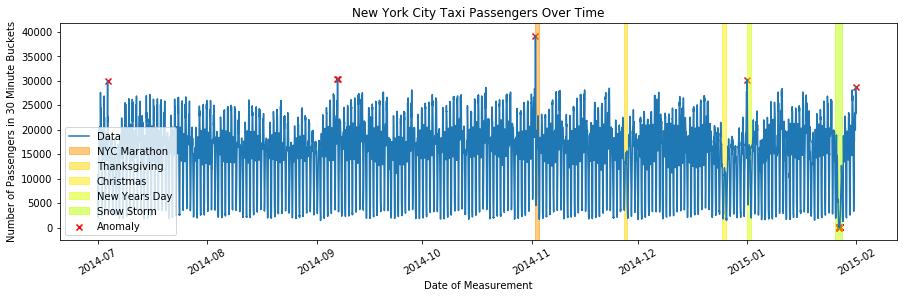

In [12]:
# Let's make this a function so we can use it later
def show_anomaly_data(anomalies):
    plt.figure(figsize=(15, 4))

    plt.plot(data[:,0], data[:,1], label="Data")
    plt.title("New York City Taxi Passengers Over Time")
    plt.xlabel("Date of Measurement")
    plt.xticks(rotation=30)
    plt.ylabel("Number of Passengers in 30 Minute Buckets")

    anomaly_data = anomalies.apply(lambda row: np.array(list((row["timestamp"], row["num_passengers"]))), axis=1)
    anomaly_data = np.array(list(anomaly_data))

    plt.scatter(anomaly_data[:,0], anomaly_data[:,1], c="red", marker="x", label="Anomaly")

    colors = cm.prism(np.linspace(0.4, 0.8, len(defined_anomalies)))
    for i, (date_name, (start_time, end_time)) in enumerate(defined_anomalies):
        plt.axvspan(start_time, end_time, color=colors[i], alpha=0.5, label=date_name)

    plt.legend(loc='lower left')
    plt.show()

anomalies = taxi_df_w_anomalies.loc[taxi_df_w_anomalies["anomaly"] != 1]
show_anomaly_data(anomalies)

This looks promising! Let's see what values we have as anomalies:

In [13]:
from datetime import date
anomalies["timestamp"].apply(lambda t: date(t.year, t.month, t.day)).unique()

array([datetime.date(2014, 7, 3), datetime.date(2014, 9, 6),
       datetime.date(2014, 11, 2), datetime.date(2015, 1, 1),
       datetime.date(2015, 1, 27), datetime.date(2015, 1, 31)],
      dtype=object)

|Anomaly Date|Significance|
|:-----------|:-----------|
|`2014-07-03`|Day Before Independence Day|
|`2014-11-02`|NYC Marathon|
|`2015-01-01`|New Years Day|
|`2015-01-27`|Snow Storm|
|`2015-01-31`|Snow Storm?|

Well, it looks like we got 3 of the mentioned 5 anomaly dates, including 1 new one that isn't mentioned in the dataset description. However, according to the Kaggle description, we're still missing **Christmas** (`2014-12-25`) and **Thanksgiving** (`2014-11-27`), so let's do some tweaking to see if we can get more of the dates:

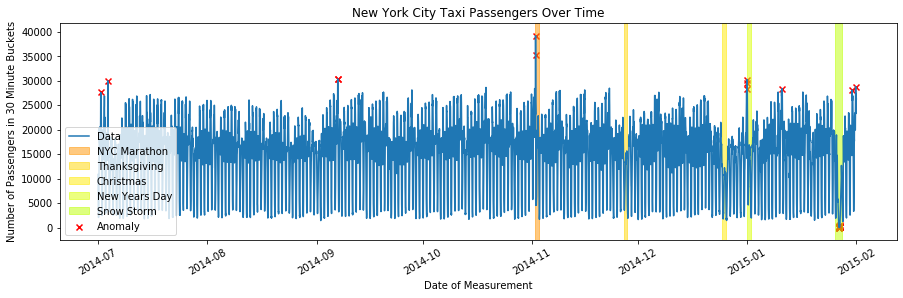

In [14]:
outliers_fraction = 0.003
if_model = IsolationForest(contamination=outliers_fraction, behaviour="new")
if_pred = if_model.fit_predict(converted_data)

taxi_df_w_anomalies = taxi_df.merge(pd.Series(if_pred, name="anomaly"), left_index=True, right_index=True)
anomalies = taxi_df_w_anomalies.loc[taxi_df_w_anomalies["anomaly"] != 1]
show_anomaly_data(anomalies)

In [15]:
anomalies["timestamp"].apply(lambda t: date(t.year, t.month, t.day)).unique()

array([datetime.date(2014, 7, 1), datetime.date(2014, 7, 3),
       datetime.date(2014, 9, 6), datetime.date(2014, 11, 2),
       datetime.date(2015, 1, 1), datetime.date(2015, 1, 10),
       datetime.date(2015, 1, 26), datetime.date(2015, 1, 27),
       datetime.date(2015, 1, 30), datetime.date(2015, 1, 31)],
      dtype=object)

Alright, more dates! Let's see what _new values_ we got:

|Anomaly Date|Significance|
|:-----------|:-----------|
|`2014-07-01`|None|
|`2014-09-06`|None|
|`2015-01-26`|Snow Storm|
|`2015-01-30`|Snow Storm?|

Well shoot, no luck. We _did_ manage to identify another date of the snow storm though! Let's see if using another model will increase our accuracy:

#### Local Outlier Factor

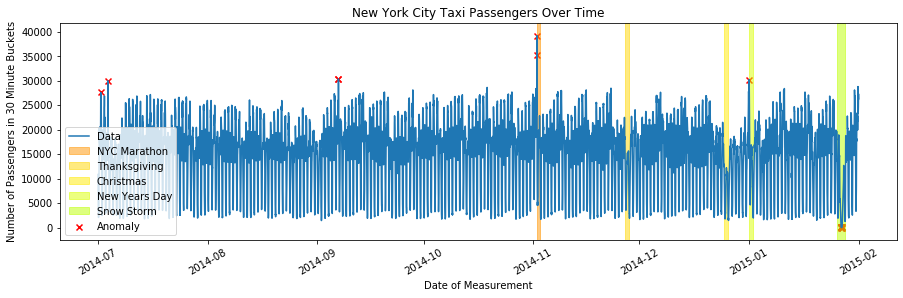

In [16]:
outliers_fraction = 0.002
lof_model = LocalOutlierFactor(n_neighbors=50, contamination=outliers_fraction)
lof_pred = lof_model.fit_predict(converted_data)

taxi_df_w_anomalies = taxi_df.merge(pd.Series(lof_pred, name="anomaly"), left_index=True, right_index=True)
anomalies = taxi_df_w_anomalies.loc[taxi_df_w_anomalies["anomaly"] != 1]
show_anomaly_data(anomalies)

In [17]:
anomalies["timestamp"].apply(lambda t: date(t.year, t.month, t.day)).unique()

array([datetime.date(2014, 7, 1), datetime.date(2014, 7, 3),
       datetime.date(2014, 9, 6), datetime.date(2014, 11, 2),
       datetime.date(2015, 1, 1), datetime.date(2015, 1, 27)],
      dtype=object)

It looks like using the `Local Outlier Factor` gets us pretty much the same result as `Isolation Forest`, but with a few more undefined anomaly dates.

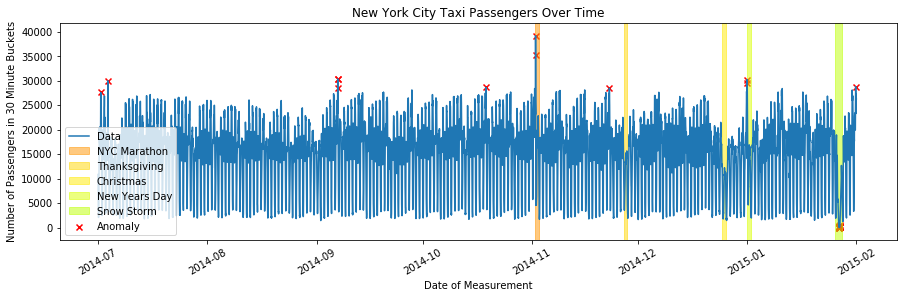

In [18]:
outliers_fraction = 0.003
lof_model = LocalOutlierFactor(n_neighbors=50, contamination=outliers_fraction)
lof_pred = lof_model.fit_predict(converted_data)

taxi_df_w_anomalies = taxi_df.merge(pd.Series(lof_pred, name="anomaly"), left_index=True, right_index=True)
anomalies = taxi_df_w_anomalies.loc[taxi_df_w_anomalies["anomaly"] != 1]
show_anomaly_data(anomalies)

In [19]:
anomalies["timestamp"].apply(lambda t: date(t.year, t.month, t.day)).unique()

array([datetime.date(2014, 7, 1), datetime.date(2014, 7, 3),
       datetime.date(2014, 9, 6), datetime.date(2014, 10, 18),
       datetime.date(2014, 11, 2), datetime.date(2014, 11, 22),
       datetime.date(2015, 1, 1), datetime.date(2015, 1, 26),
       datetime.date(2015, 1, 27), datetime.date(2015, 1, 31)],
      dtype=object)

Increasing our outliers fraction functioned a similar way to the `Isolation Forest`, as we got more undefined dates but no new defined dates.

## Conclusion
In the end, our best anomaly detection model (`Isolation Forest with 0.002 outliers fraction`) was shown to identify **3 / 5** of the defined anomaly dates, with only **1** undefined date. This is a very good result, as a look at the graph shows that the model did a great job at finding the outliers, whether they be due to increased taxi passenger count or decreased taxi passenger count.

Unsurprisingly, when we increased the outliers fraction to `0.003`, our `Isolation Forest` model predicted more anomaly points, although these new anomaly dates were not defined in the Kaggle description. When we tried using `Local Outlier Factor`, we ended up with a similar result.

Why couldn't our models identify **Thanksgiving** or **Christmas**? I believe that it may be due to the fact that on those days there were fewer taxi passengers during the day when normally there are more. This occurence did not create an extreme point (a data point outside of the typical range of points), but it did create a change in the cyclic pattern. It seems that our models are just finding these extreme points that lie outside of the average range of data points, not necessarily finding anomalies in cyclic time-series data.